## Dynamic flux based analysis


#### Introductory stuff - import of various libraries needed for DFBA and the model

In [1]:
%run 01-model.ipynb

from dfba import DfbaModel, ExchangeFlux, KineticVariable
from dfba.plot.matplotlib import *

'' is not a valid SBML 'SId'.


Defining the model objective to optimize the psilosybin synthase.

In [2]:
model.objective = model.reactions.psiM
model.optimize();

### DFBA starts here

In [3]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

In [4]:
X = KineticVariable("Biomass")
Glc = KineticVariable("Glucose")
Psi = KineticVariable("Psilocybin")
Oxy = KineticVariable("Oxygen")
#Trp = KineticVariable("Tryptophan")

dfba_model.add_kinetic_variables([X, Glc, Psi, Oxy])

In [5]:
mu = ExchangeFlux("DRAIN_Biomass")
v_G = ExchangeFlux("BOUNDARY_GLCe")
v_Psi = ExchangeFlux("psiM")
v_O = ExchangeFlux("BOUNDARY_O2e")
#v_Trp = ExchangeFlux("r385")


dfba_model.add_exchange_fluxes([mu, v_G, v_Psi, v_O])

In [6]:
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_G * 180.1559/1000 * X)
dfba_model.add_rhs_expression("Psilocybin", v_Psi * 284.25/1000.0 * X)
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant
#dfba_model.add_rhs_expression("Tryptophan", v_Trp * 204.22/1000.0 * X)

In [7]:
dfba_model.add_exchange_flux_lb("BOUNDARY_GLCe", 2.5 * (Glc / (0.0027 + Glc)), Glc)
dfba_model.add_exchange_flux_lb("BOUNDARY_O2e", 15.0 * (Oxy / (0.024 + Oxy)), Oxy)
dfba_model.add_exchange_flux_lb("psiM", 3.14 * (Psi / (0.01 + Psi)), Psi)

#dfba_model.add_exchange_flux_lb("r385", 48.219 * (Trp / (0.02 + Trp)), Trp)

In [8]:
%time

dfba_model.add_initial_conditions(
    {
        "Biomass": 1,       # (gDW/L)
        #"Tryptophan": 0.01, # (g/L)
        "Glucose": 20.0,    # (g/L)
        "Psilocybin": 0.0,  # (g/L)
        "Oxygen": 39        # (mmol/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 75.0, 0.1, ["BOUNDARY_GLCe", "psiM"])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs


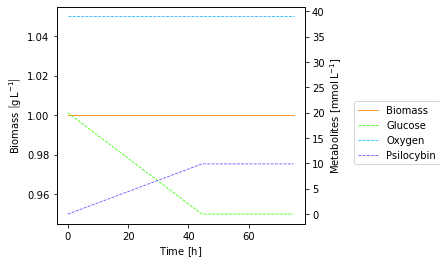

In [9]:
plot_concentrations(concentrations)

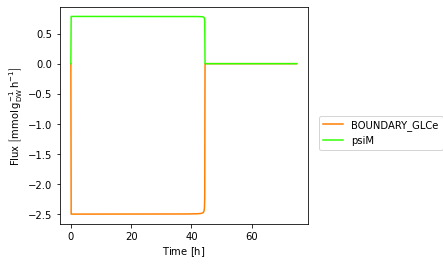

In [10]:
plot_trajectories(trajectories)